In [3]:
import json
import datetime

data = json.load(open('user_project_times.json'))

In [4]:
def convert_time(el):
    el = int(str(el)[:10])
    return datetime.date.fromtimestamp(el)

In [5]:
# make one sweep through data to get global upper and lower bounds of creation times
earliest = 1e100
latest = 0
for user in data:
    for ctime, _ in data[user]: #ignore last-modified for now
        if ctime < earliest:
            earliest = ctime
        if ctime > latest:
            latest = ctime

print 'Earliest:', convert_time(earliest) 
print 'Latest:', convert_time(latest)

Earliest: 2013-03-27
Latest: 2016-03-10


For exploratory analysis, let's divide this interval into days, and count the number of projects created each day

In [6]:
days = (latest-earliest)/(86400.*1000)
print days, 'days in timespan'

import numpy
project_counts = numpy.zeros(int(days+1))

1079.18398146 days in timespan


In [7]:
for user in data:
    for ctime, _ in data[user]: 
        cday = int((ctime-earliest)/(86400.*1000))
        project_counts[cday] += 1

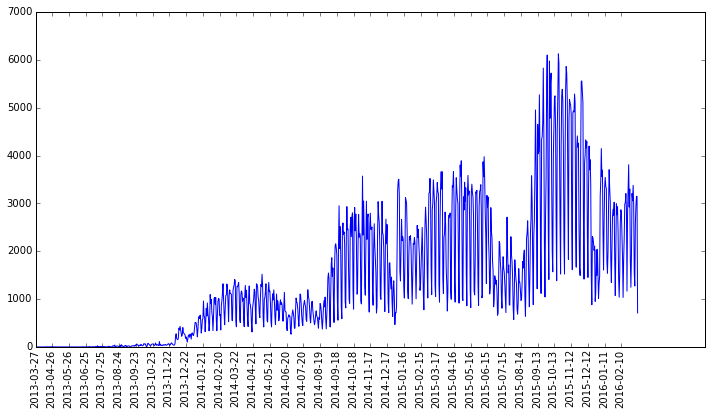

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
matplotlib.rcParams['figure.figsize'] = (12, 6)

def time_plot(arr):
    plt.plot(range(arr.size), arr)
    xtoshow = range(0, arr.size, 30)
    plt.xticks(xtoshow, [str(convert_time(x*86400*1000 + earliest)) for x in xtoshow], rotation=90)
    plt.show()
    
time_plot(project_counts)

We see distinct bursts in the Fall and Spring semesters.

Let's look at the number of distinct users on each day.

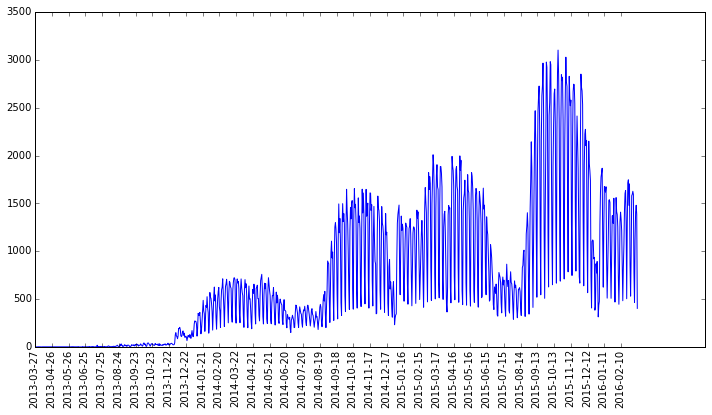

In [9]:
user_counts = numpy.zeros(int(days+1))
for user in data:
    thisuser_counts = numpy.zeros(int(days+1))
    for ctime, _ in data[user]: 
        cday = int((ctime-earliest)/(86400.*1000))
        thisuser_counts[cday] = 1
    user_counts += thisuser_counts
    
time_plot(user_counts)

Not too different.

Now let's get the length of activity for each user (still using creation times) in days. 

In [10]:
user_activity_length = numpy.zeros(len(data))
for i, user in enumerate(data.keys()):
    ctimes = [ctime for ctime, _ in data[user]]
    user_activity_length[i] = (max(ctimes) - min(ctimes))/(86400*1000)

The histogram shows the number of users whose activity time was within `x` number of days.

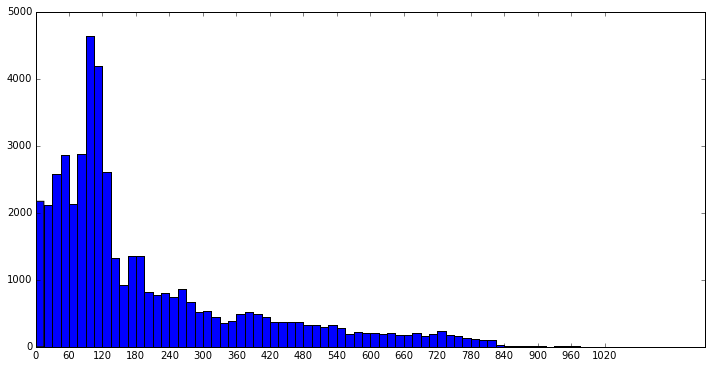

In [11]:
plt.hist(user_activity_length, bins=range(0, int(max(user_activity_length))+1, 15))
plt.xticks(range(0, int(max(user_activity_length))+1, 60))
plt.show()

Seems like the majority of users are active for less than 120 days, which is about the length of a semester. Modal user activity is 90-120 days, which is about the length of a semester. 

**Question:** what predicts whether a user will stay on beyond some MINDUR days, using the first MINDUR days of activity?

Features: Number of projects created at 10% (12-day) intervals, or similar.

Characterize all users based on their activities in their first MINDUR days according to these features. 

Filtered to 25324 users from 46319


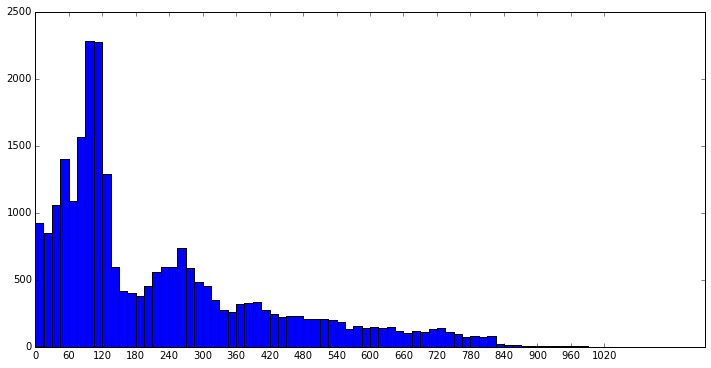

In [12]:
MAXDUR = 300
MINDUR = 150
# get subset of data from "old" users whose earliest creation date is more than MAXDUR days before the end of the dataset
# (giving them a good chance to stay on for more than MINDUR days),
# AND have activity within MAXDUR days if they are active beyond MINDUR (to be fair to recent users)
old_data = {}
for user in data:
    start_time = min([ctime for ctime, _ in data[user]])
    if int((latest-start_time)/(86400.*1000))>MAXDUR:
        post = filter(lambda length: length>MINDUR, 
                      map(lambda (ctime,mtime): (ctime-start_time)/(86400.*1000), data[user]))
        if len(post)>0 and len(filter(lambda length: length<=MAXDUR, post))==0:
            continue  # ignore users who have no activity in the 120-180 period
        old_data[user] = data[user]
print 'Filtered to', len(old_data), 'users from', len(data)

old_user_activity_length = numpy.zeros(len(old_data))
for i, user in enumerate(old_data.keys()):
    ctimes = [ctime for ctime, _ in data[user]]
    old_user_activity_length[i] = (max(ctimes) - min(ctimes))/(86400*1000)
    
plt.hist(old_user_activity_length, bins=range(0, int(max(old_user_activity_length))+1, 15))
plt.xticks(range(0, int(max(old_user_activity_length))+1, 60))
plt.show()

In [13]:
def getAverageProjectLen(user):
    num_projects = len(user) # total number of projects done by user 
    total_project_length = 0 #the sum of all the lengths of the project (from date created to date modified)
    for project in user: 
        total_project_length += (project[1] - project[0])/(86400.*1000)   #SR: added this to scale to days
    return int(total_project_length / num_projects)

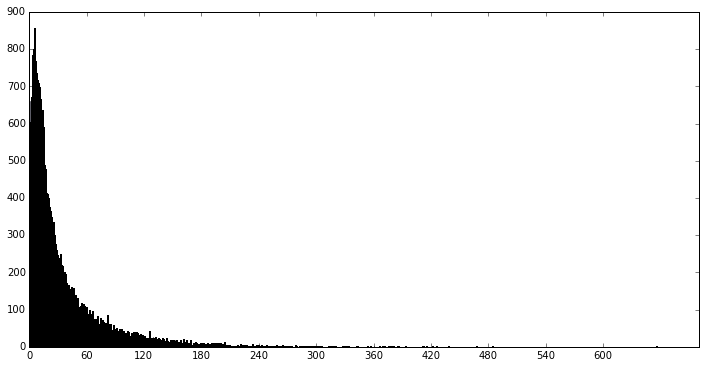

In [14]:
# more attempts (failure so far) to get a histogram to show up :(
# SR: fixed -- the scale was too high in unconverted unix time :)
length_list = []
keys = old_data.keys()
for user in keys:
    length_list.append(getAverageProjectLen(old_data[user]))

plt.hist(length_list, bins=range(0, int(max(length_list)+1)))
plt.xticks(range(0, int(max(length_list))+1, 60))
plt.show()

In [15]:

import time 
#timedelta 
#make time 

def getProjectsMINDUR(user):
    earliest = int(user[0][0]) #tested that first project is earliest
    latest = (MINDUR * 86400 * 1000) + earliest
    #print "latest " + str(latest)
    project_list = []

    for project in user: 
        if latest - int(project[0]) > 0:
            project_list.append(project)
    return project_list

In [16]:
def percentProjects(user, percent): 
    data =  getProjectsMINDUR(user)
    first_project = data[0][0]
    last_project = data[len(data)-1][1]
    total_time = last_project - first_project
    percent_time = (total_time * percent/100) + first_project
    project_matches = 0
    for project in data: 
        if project[0] <= percent_time: 
            project_matches += 1
    return project_matches
        


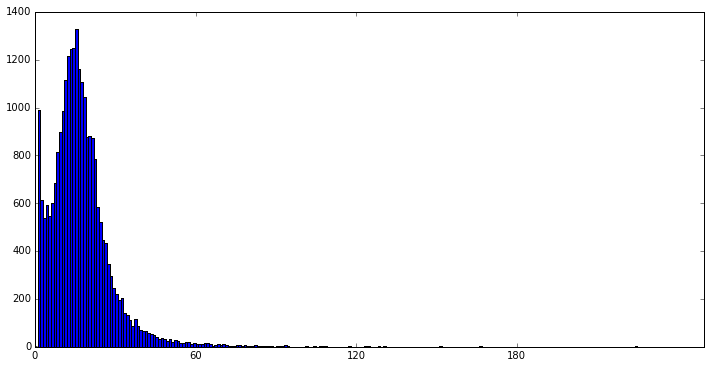

In [17]:
keys = old_data.keys()
length_list = []
for user in keys:
    length_list.append(percentProjects(old_data[user],50))

plt.hist(length_list, bins=range(0, int(max(length_list)+1)))
plt.xticks(range(0, int(max(length_list))+1, 60))
plt.show()

In [18]:
def numberOfProjects(user):
    return len(user)

In [19]:
def numberOfProjectsMINDUR(user):
    data= getProjectsMINDUR(user)
    return len(data)
    

In [20]:
# i = 0
# for user in keys: 
#     if i < 20: 
#         print "before" + str(numberOfProjects(old_data[user]))
#         print "after" + str(numberOfProjectsMINDUR(old_data[user]))
#         i+=1

In [21]:
import datetime
def percentOnDay(user, day):
    data =  getProjectsMINDUR(user)
    num_projs = len(data)
    weekday_projs = 0
    for project in data: 
        if datetime.datetime.fromtimestamp(project[0] / 1e3).weekday() == day: 
            weekday_projs += 1.0
    return weekday_projs / num_projs * 100

In [22]:
def percentOnWeekday(user):
    data =  getProjectsMINDUR(user)
    num_projs = len(data)
    weekday_projs = 0
    for project in data: 
        if datetime.datetime.fromtimestamp(project[0] / 1e3).weekday() < 6: 
            weekday_projs += 1.0
    return weekday_projs / num_projs * 100
    

In [23]:
#returns the number of projects a user started in a particular decile... doesn't always get all projects :(
def numProjectsInDecile(user, dec):
    ''' the first decile is the 0th decile (covering from 0-10% of the time), 
    the last decile is the 9th decile'''
    data =  getProjectsMINDUR(user)

    first = data[0][0]
    last = data[len(data)-1][0]
    decile_width = (last - first) / 10.0
    project_list = []
    
    first_included = first + (decile_width * (dec -1)) 
    last_included = first + (decile_width * dec)
    
    for project in data: 
        if project[0] >= first_included and project[0] <= last_included: 
            project_list.append(project)
    num_projects = float(len(project_list)) #get the number of projects created in the MINDUR 
    return num_projects/len(data)
    
    

In [24]:
# decile testing
# k = old_data.keys() 
# i = 0
# s = 0
# for user in k: 
#     s = 0
#     for x in range(10):
#         s += numProjectsInDecile(old_data[user],x)
#     print s 
    
    

In [25]:
from sklearn.feature_extraction import DictVectorizer

def percentProjectsFeatures(user):
    """return a dictionary mapping each time slot (10%, 20%, etc) to the percentage of projects created
    at that time,
    for a particular user represented as list of (creation times, modified times),
    using only their first MINDUR days of activity"""   
    userDict = {} 
    #note: feature names are for our reference only
    userDict["average length"] = getAverageProjectLen(user)
    userDict["ten percent"] =  percentProjects(user, 10)
    userDict["twenty percent"] = percentProjects(user, 20)
    userDict["thirty percent"] =  percentProjects(user, 30)
    userDict["forty percent"] = percentProjects(user, 40)
    userDict["fifty percent"] =  percentProjects(user, 50)
    userDict["sixty percent"] = percentProjects(user, 60)
    userDict["seventy percent"] =  percentProjects(user, 70)
    userDict["eighty percent"] = percentProjects(user, 80)
    userDict["ninety percent"] =  percentProjects(user, 90)
    userDict["hundred percent"] = percentProjects(user, 100)
    return userDict


In [26]:
users_percent_dicts = map(percentProjectsFeatures, old_data.values())
vec = DictVectorizer()
X = vec.fit_transform(users_percent_dicts) # converts to array: http://scikit-learn.org/stable/modules/feature_extraction.html

In [27]:
def dayAnalysisFeatures(user): 
    userDict = {} 
    userDict["weekday"] = percentOnWeekday(user)
    userDict["Monday"] = percentOnDay(user, 0)
    userDict["Tuesday"] = percentOnDay(user, 1)
    userDict["Wednesday"] = percentOnDay(user, 2)
    userDict["Thursday"] = percentOnDay(user, 3)
    userDict["Friday"] = percentOnDay(user, 4)
    userDict["Saturday"] = percentOnDay(user, 5)
    userDict["Sunday"] = percentOnDay(user, 6)

    return userDict

In [28]:
def decileFeatures(user): 
    userDict = {} 
    #userDict["1st"] = numProjectsInDecile(user, 0)
    userDict["2nd"] = numProjectsInDecile(user, 1)
    userDict["3rd"] = numProjectsInDecile(user, 2)
    userDict["4th"] = numProjectsInDecile(user, 3)
    userDict["5th"] = numProjectsInDecile(user, 4)
    userDict["6th"] = numProjectsInDecile(user, 5)
    userDict["7th"] = numProjectsInDecile(user, 6)
    userDict["8th"] = numProjectsInDecile(user, 7)
    userDict["8th"] = numProjectsInDecile(user, 8)
    #userDict["9th"] = numProjectsInDecile(user, 9)
    
    return userDict

Write other feature functions -- perhaps different interval sizes (instead of 10%), proportion of projects rather than number, etc. With some effort, we can get a measure of activity on weekends/evenings as features too. Experiment...

Give each feature function a distinct name, and re-run the above two cells with the function in place of `featurize` to see if the contingency tables change

Remember from the CS111 assignment that we can combine a list of feature functions to give a new feature function, so you should experiment with combinations as well.

In [29]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

In [33]:
user_dicts = []
i = 0
for user in old_data: #user is just the user's id num 
    combined = combine_featfuncs([percentProjectsFeatures, dayAnalysisFeatures, decileFeatures]) #a function object is being returned here?? 
    user_dicts.append(combined(old_data[user]))

vec = DictVectorizer()
X = vec.fit_transform(user_dicts) # converts to array: http://scikit-learn.org/stable/modules/feature_extraction.html



{'fifty percent': 19, 'eighty percent': 20, '5th': 0.09523809523809523, 'Wednesday': 0, 'forty percent': 14, '3rd': 0.14285714285714285, 'Sunday': 42.857142857142854, 'sixty percent': 19, 'Thursday': 0, '7th': 0.19047619047619047, 'average length': 3, '2nd': 0.047619047619047616, 'thirty percent': 13, 'Monday': 57.14285714285714, 'ninety percent': 21, '6th': 0.09523809523809523, 'Tuesday': 0, 'Friday': 0, 'ten percent': 1, 'hundred percent': 21, '4th': 0.3333333333333333, 'weekday': 57.14285714285714, 'seventy percent': 19, 'twenty percent': 4, 'Saturday': 0, '8th': 0.0}


**Attempt 1: Clustering.** Is there any correlation between the clusters produced by these features, and whether or not a user is retained?

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
users_clusterids = model.fit_predict(X)

from scipy.stats import chi2_contingency
conting = numpy.zeros((2, 2))  # row = cluster ID (0, 1), col = #days (0 for <=120, 1 for >120)

for i in range(len(users_clusterids)):
    cluster = users_clusterids[i]
    if old_user_activity_length[i]<=MINDUR:
        conting[cluster, 0] += 1
    else:
        conting[cluster, 1] += 1

# visualize
print conting

# compute chi2 statistic to get the probability that there is no association between
# the clustering and whether or not the user is active for >120 days
# lower probabilities are better
_, p, _, _ = chi2_contingency(conting)
print 'There is a', p, 'probability that the clusters and retention are independent.'

**Attempt 2: Classification.**

In [ ]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

y = numpy.array(map(lambda d: int(d>MINDUR), old_user_activity_length))  # labels (0 for less than MINDUR, 1 otherwise)
percentpos = sum(y)/float(len(y))
chance = max(percentpos, 1-percentpos)
print 'Chance is', chance

print 'Building a model with', X.shape[1], 'features'

for trainidx, testidx in StratifiedKFold(y):
    Xtrain = X[trainidx, :]  # using numpy's smart indexing
    Xtest = X[testidx, :]
    ytrain = y[trainidx]
    ytest = y[testidx]
    for i in range(2,10):
        model = KNeighborsClassifier(n_neighbors=i)  # TODO: experiment with number of neighbors
        model.fit(Xtrain, ytrain)
        ypred = model.predict(Xtest)
        